# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: 
Fecha de entrega: 11 de diciembre de 2020

In [ ]:
import os
import sys
import random
import pickle

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

!pip install torchsummary
from torchsummary import summary
!pip install ipdb
import ipdb

In [3]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-w64vzrym/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-w64vzrym/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5800 sha256=4875b876ce6a0b040b8592b52c1c0a3c41cb2b25e2e73b04127309b5cfa91638
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhs_flge/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
Connection stablished


In [4]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [5]:
# Como todas las capas convolucionales del paper usan ReLu, se va a hacer una clase general para facilitar esto:
class Conv2dRelu(nn.Module):
  def __init__(
      self, 
      in_channels,
      out_channels, 
      **kwargs
  ):
    super(Conv2dRelu, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)

  def forward(self, x):
    x = self.conv(x)
    return F.relu(x)

In [6]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    # Rama 1: Conv2d 1x1 -> Conv2d 3x3
    self.branch1 = nn.Sequential(
        Conv2dRelu(in_channels, ch_3x3_reduce, kernel_size=1),
        Conv2dRelu(ch_3x3_reduce, ch_3x3, kernel_size=3, padding=1)
    )
    # Rama 2: Conv2dRelu 1x1 -> Conv2dRelu 5x5
    self.branch2 = nn.Sequential(
        Conv2dRelu(in_channels, ch_5x5_reduce, kernel_size=1),
        Conv2dRelu(ch_5x5_reduce, ch_5x5, kernel_size=5, padding=2)
    )

    # Rama 3: Max_Pool -> Conv2dRelu 1x1
    self.branch3 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
        Conv2dRelu(in_channels, ch_pool_proj, kernel_size=1)
    )

    # Rama 4: Conv2dRelu 1x1
    self.branch4 = Conv2dRelu(in_channels, ch_1x1, kernel_size=1)
        

  def _forward(self, x):
    # aux para forward:
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)

    outputs = [branch1, branch2, branch3, branch4]
    return outputs


  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    outputs = self._forward(x)
    return torch.cat(outputs, 1)

Esta celda se utiliza para chequear que los tamanos del output sean los correctos.

In [7]:
# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

with torch.no_grad():
  model = InceptionModule(in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj)
  s = timer()
  result = model._forward(torch.tensor(x))
  for r in result:
    print(r.shape)

torch.Size([5, 128, 28, 28])
torch.Size([5, 16, 28, 28])
torch.Size([5, 32, 28, 28])
torch.Size([5, 32, 28, 28])


In [8]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Using cached test data
Correct Test!


## 1b) GoogLeNet

In [9]:
# Modulo auxiliar de prediccion intermedia:
class InceptionAux(nn.Module):
  def __init__(
      self, 
      in_channels, 
      num_classes
  ):
    super(InceptionAux,self).__init__()
    #self.avgpool = nn.AvgPool2d(kernel_size= 5,stride=3)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.conv = Conv2dRelu(in_channels, 128, kernel_size=1)

    self.fc1 = nn.Linear(128,1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.avgpool(x)
    x = self.conv(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x, inplace=True)
    x = F.dropout(x, 0.7, training=self.training)
    x = self.fc2(x)

    return x


In [10]:
# basado en la documentacion de Pytorch/Vision/GoogLeNet. 
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()
    self.use_aux_logits = use_aux_logits
    # Define las capas de convolución y pooling de GoogLeNet
    # Conv 1
    self.conv1 = Conv2dRelu(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
    # Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
    
    # Conv 2
    self.conv2 = Conv2dRelu(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
    # Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # in_channels, ch_3x3_reduce=96, ch_5x5_reduce=16,
    # ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64

    # Inception 3a
    self.inception3a = InceptionModule(in_channels=192, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64)
    # Inception 3b
    self.inception3b = InceptionModule(in_channels=256, ch_3x3_reduce=128, ch_5x5_reduce=32, ch_3x3=192, ch_5x5=96, ch_pool_proj=64, ch_1x1=128)

    # Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # Inception 4a
    self.inception4a = InceptionModule(in_channels=480, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=208, ch_5x5=48, ch_pool_proj=64, ch_1x1=192)
    # Inception 4b
    self.inception4b = InceptionModule(in_channels=512, ch_3x3_reduce=112, ch_5x5_reduce=24, ch_3x3=224, ch_5x5=64, ch_pool_proj=64, ch_1x1=160)
    # Inception 4c
    self.inception4c = InceptionModule(in_channels=512, ch_3x3_reduce=128, ch_5x5_reduce=24, ch_3x3=256, ch_5x5=64, ch_pool_proj=64, ch_1x1=128)
    # Inception 4d
    self.inception4d = InceptionModule(in_channels=512, ch_3x3_reduce=144, ch_5x5_reduce=32, ch_3x3=288, ch_5x5=64, ch_pool_proj=64, ch_1x1=112)
    # Inception 4e
    self.inception4e = InceptionModule(in_channels=528, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)

    # Max Pool 4
    self.maxpool4  = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # Inception 5a
    self.inception5a = InceptionModule(in_channels=832, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    # Inception 5b
    self.inception5b = InceptionModule(in_channels=832, ch_3x3_reduce=192, ch_5x5_reduce=48, ch_3x3=384, ch_5x5=128, ch_pool_proj=128, ch_1x1=384)

    # Avg Pool
    #self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # Dropout .4
    self.dropout = nn.Dropout2d(0.4)

    # Linear
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

    # Decide si usar la clasificación auxiliar
    if self.use_aux_logits:
      self.aux1 = InceptionAux(512, n_classes)
      self.aux2 = InceptionAux(528, n_classes)
    else:
      self.aux1 = None  # type: ignore[assignment]
      self.aux2 = None

  def forward(self, x):
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None
    x = self.conv1(x)
    
    x = self.maxpool1(x)
    
    x = self.conv2(x)
    
    x = self.maxpool2(x)


    x = self.inception3a(x)
  
    x = self.inception3b(x)

    x = self.maxpool3(x)
    
    x = self.inception4a(x)

    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits:
      if self.training:
        aux1_out = self.aux1(x)
        aux_logits.append(aux1_out)
    else:
      aux1_out = None
    

    x = self.inception4b(x)
    
    x = self.inception4c(x)
    
    x = self.inception4d(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits:
      if self.training:
        aux2_out = self.aux2(x)
        aux_logits.append(aux2_out)
    else:
      aux2_out = None

    # Continúa computando las representaciones internas de la red
    x = self.inception4e(x)
    
    x = self.maxpool4(x)


    x = self.inception5a(x)
    hidden = x.detach().clone()
    x = self.inception5b(x)
    

    x = self.avgpool(x)
    
    x = torch.flatten(x, 1)
    
    x = self.dropout(x)
    x = self.fc_out(x)
    
    #return x, aux2_out, aux1_out

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': x, 'aux_logits': aux_logits}

In [19]:
ver_resumen = False
if ver_resumen:
  device = 'cuda'
  test_model = GoogLeNet(n_classes=1000, use_aux_logits=True).to(device)
  summary(test_model, input_size=(3, 32, 32))

In [12]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=True)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) Arquitectura Convolucional: _____



In [30]:
import requests
import io

In [31]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [32]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

In [33]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [34]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [35]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [36]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [48]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

In [ ]:
model_ResNetV2 = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=10, zero_head=True)
model_ResNetV2.load_from(weights)


In [50]:
# Yes, we still use 512 batch-size! Maybe something else is even better, who knows.
# loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=512, shuffle=True, num_workers=2)

# NOTE: This is necessary when the batch-size is larger than the dataset.
sampler = torch.utils.data.RandomSampler(train_5shot, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=256, num_workers=2, sampler=sampler)

NameError: ignored

In [ ]:
# # Acá el código para tu primera arquitectura

# class ResNetV2(nn.Module):
#   def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
#     super(ResNetV2, self).__init__()


#     # Capa de salida (antes de la función de salida)
#     self.fc_out = nn.Linear(..., n_classes)

#   def forward(self, x):
#     # Computa las representaciones internas de la red
#     ...

#     # N x out_size
#     logits = self.fc_out(...)

#     # En hidden debes devolver alguna de las capas oculta de la red
#     return {'hidden': ..., 'logits': logits}

## 1d) Clasificación de Imágenes en CIFAR10

In [13]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Se utilizara el siguiente `lr_scheduler`:
 [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR). 

Este se propone en el paper [SGDR: STOCHASTIC GRADIENT DESCENT WITH WARM RESTARTS](https://arxiv.org/pdf/1608.03983.pdf). En este, afirman que utilizando los `Warm Restarts`, se pueden lograr resultados competitivos en `CIFAR10` y `CIFAR100` aproximadamente dos a cuatro veces mas rapido. 


Epoch:1(50000/50000), lr:0.0010000, Loss:1.90340, Train Acc:20.1%, Validating..., Val Acc:20.86%, Avg-Time:53.887s.
Epoch:2(50000/50000), lr:0.0010000, Loss:1.60525, Train Acc:34.8%, Validating..., Val Acc:46.16%, Avg-Time:53.973s.
Epoch:3(50000/50000), lr:0.0010000, Loss:1.31642, Train Acc:50.9%, Validating..., Val Acc:51.82%, Avg-Time:53.906s.
Epoch:4(50000/50000), lr:0.0010000, Loss:1.15339, Train Acc:58.2%, Validating..., Val Acc:59.88%, Avg-Time:53.966s.
Epoch:5(50000/50000), lr:0.0010000, Loss:1.03727, Train Acc:63.3%, Validating..., Val Acc:63.43%, Avg-Time:53.922s.
Epoch:6(50000/50000), lr:0.0010000, Loss:0.95530, Train Acc:66.7%, Validating..., Val Acc:66.58%, Avg-Time:53.751s.
Epoch:7(50000/50000), lr:0.0010000, Loss:0.88111, Train Acc:69.4%, Validating..., Val Acc:68.89%, Avg-Time:53.703s.
Epoch:8(50000/50000), lr:0.0010000, Loss:0.81947, Train Acc:71.4%, Validating..., Val Acc:69.38%, Avg-Time:53.586s.
Epoch:9(50000/50000), lr:0.0009999, Loss:0.77141, Train Acc:73.4%, Valid

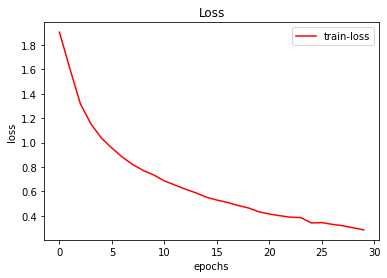

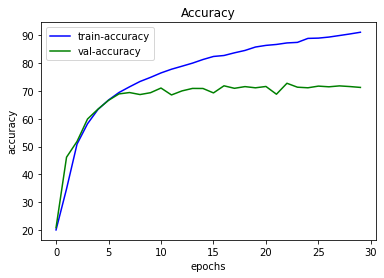

In [18]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

net =  GoogLeNet(n_classes=10, use_aux_logits=True)# tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
# (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

# ipdb.set_trace()
# train_loss, acc = train_for_classification(net, train_loader, test_loader, optimizer, criterion)
train_loss, acc = train_for_classification(net, train_loader, test_loader, optimizer, criterion, scheduler,epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

In [51]:
def train_for_classification2(net, train_loader, test_loader, optimizer, 
                             criterion, lr_scheduler=None,
                             epochs=1, reports_every=1, device='cuda'):
  net.to(device)
  total_train = len(train_loader.dataset)
  total_test = len(test_loader.dataset)
  tiempo_epochs = 0
  train_loss, train_acc, test_acc = [], [], []

  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    # Aseguramos que todos los parámetros se entrenarán usando .train()
    net.train()

    # Variables para las métricas
    running_loss, running_acc = 0.0, 0.0

    for i, data in enumerate(train_loader):
      # Desagregamos los datos y los pasamos a la GPU
      X, Y = data
      X, Y = X.to(device), Y.to(device)

      # Limpiamos los gradientes, pasamos el input por la red, calculamos
      # la loss, ejecutamos el backpropagation (.backward) 
      # y un paso del optimizador para modificar los parámetros
      optimizer.zero_grad()

      out_dict = net(X)
      # Y_logits = out_dict['logits']
      loss = criterion(out_dict, Y)

      
      loss.backward()
      optimizer.step()

      # loss
      items = min(total_train, (i+1) * train_loader.batch_size)
      running_loss += loss.item()
      avg_loss = running_loss/(i+1)
      
      # accuracy
      _, max_idx = torch.max(out_dict, dim=1)
      running_acc += torch.sum(max_idx == Y).item()
      avg_acc = running_acc/items*100

      # report
      sys.stdout.write(f'\rEpoch:{e}({items}/{total_train}), ' 
                       + (f'lr:{lr_scheduler.get_last_lr()[0]:02.7f}, ' if lr_scheduler is not None else '')
                       + f'Loss:{avg_loss:02.5f}, '
                       + f'Train Acc:{avg_acc:02.1f}%')
      
    tiempo_epochs += timer() - inicio_epoch

    if e % reports_every == 0:
      sys.stdout.write(', Validating...')
      train_loss.append(avg_loss)
      train_acc.append(avg_acc)
      net.eval()
      running_acc = 0.0
      for i, data in enumerate(test_loader):
        X, Y = data
        X, Y = X.to(device), Y.to(device)
        Y_logits = net(X)
        _, max_idx = torch.max(Y_logits, dim=1)
        running_acc += torch.sum(max_idx == Y).item()
        avg_acc = running_acc/total_test*100
      test_acc.append(avg_acc)
      sys.stdout.write(f', Val Acc:{avg_acc:02.2f}%, '
                       + f'Avg-Time:{tiempo_epochs/e:.3f}s.\n')
    else:
      sys.stdout.write('\n')

    if lr_scheduler is not None:
      lr_scheduler.step()

  return train_loss, (train_acc, test_acc)

Epoch:1(50000/50000), lr:0.0010000, Loss:1.26306, Train Acc:54.4%, Validating..., Val Acc:67.36%, Avg-Time:139.221s.
Epoch:2(50000/50000), lr:0.0010000, Loss:0.79045, Train Acc:73.2%, Validating..., Val Acc:74.12%, Avg-Time:139.055s.
Epoch:3(50000/50000), lr:0.0010000, Loss:0.61169, Train Acc:79.4%, Validating..., Val Acc:77.61%, Avg-Time:139.128s.
Epoch:4(50000/50000), lr:0.0010000, Loss:0.50029, Train Acc:83.0%, Validating..., Val Acc:78.17%, Avg-Time:139.036s.
Epoch:5(50000/50000), lr:0.0010000, Loss:0.40138, Train Acc:86.5%, Validating..., Val Acc:79.10%, Avg-Time:138.956s.
Epoch:6(50000/50000), lr:0.0010000, Loss:0.31900, Train Acc:89.2%, Validating..., Val Acc:79.25%, Avg-Time:138.891s.
Epoch:7(50000/50000), lr:0.0010000, Loss:0.25478, Train Acc:91.5%, Validating..., Val Acc:80.08%, Avg-Time:138.870s.
Epoch:8(50000/50000), lr:0.0010000, Loss:0.20832, Train Acc:93.1%, Validating..., Val Acc:80.71%, Avg-Time:138.779s.
Epoch:9(50000/50000), lr:0.0009999, Loss:0.17385, Train Acc:94.1

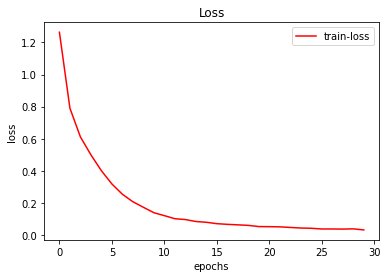

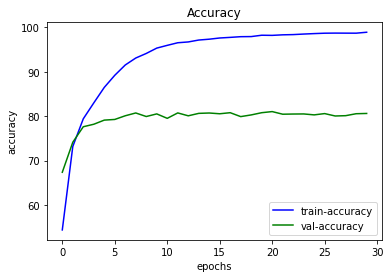

In [52]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)


optimizer = optim.Adam(model_ResNetV2.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
# (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

# ipdb.set_trace()
# train_loss, acc = train_for_classification(model_ResNetV2, train_loader, test_loader, optimizer, criterion)
train_loss, acc = train_for_classification2(model_ResNetV2, train_loader, test_loader, optimizer, criterion, scheduler,epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Failed Test! [acc]


## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    ...

  def forward(self, x):
    x = self.cnn_model(x)['hidden']

    # Compute las capas de su MLP
    ...

    # En fc_out debe almacenar el encoding en R^d
    return {'logits': ...}

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    ...

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    ...

    # En logits debe almacenar el encoding en R^d
    return {'logits': ...}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet()
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=1024, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = ...

    # Obtener distancias "positivas" de la diagonal
    p_dists = ...

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = ...
    elif self.negative == 'random':
      cost = ...
    elif self.negative == 'all':
      cost = ...
    else:
      raise ValueError()
    
    # Retorna el promedio de los costos de todos los triples considerados
    return ...

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = ...
REPORTS_EVERY = 1
CNN_OUT_SIZE = ...
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = ...

cnn_net = ...
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},  # lista de parametros de img_net
                        {'params': ...}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, scheduler, EPOCHS, 
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},
                        {'params': ...}], 
                       lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion, 
                                                     EPOCHS, REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')